In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT (80/20 split) ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) MinMaxScaler cho X & y (fit trên TRAIN) ==================
xs = MinMaxScaler()
ys = MinMaxScaler()

X_train_prepared = xs.fit_transform(X_train)
X_test_prepared  = xs.transform(X_test)

y_train_prepared = ys.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_prepared  = ys.transform(y_test.values.reshape(-1, 1)).ravel()

# ================== 4) RandomizedSearchCV (CatBoost) ==================
param_distributions = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.01, 0.03, 0.1, 0.2],
    "max_depth": [4, 6, 8, 10],     # <-- 'depth' (không phải 'max_depth')
}

model = LGBMRegressor()

ran_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,                               
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=SEED
)

ran_search.fit(X_train_prepared, y_train_prepared)

best_model   = ran_search.best_estimator_
best_params  = ran_search.best_params_
best_cv_rmse = np.sqrt(-ran_search.best_score_)   # RMSE trên THANG ĐÃ SCALE (y đã scale)

print("Best params:", best_params)
print(f"Best CV RMSE (scaled y): {best_cv_rmse:.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 361692, number of used features: 7
[LightGBM] [Info] Start training from score 0.019173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best params: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.2}
Best CV RMSE (scaled y): 0.006406


In [4]:
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (ALL METRICS ON SCALED) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit on train fold only) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_tr_s = xs.fit_transform(X_tr)
    X_te_s = xs.transform(X_te)
    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()

    # --- LightGBM ---
    model = LGBMRegressor(random_state=SEED, verbose=-1,n_estimators= 200, max_depth= 8, learning_rate= 0.2)
    model.fit(X_tr_s, y_tr_s)

    # --- predict & metrics on SCALED values ---
    y_pred_s = model.predict(X_te_s)



    mse  = mean_squared_error(y_te_s, y_pred_s)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse); mae_scores.append(mae)
    rmse_scores.append(rmse); r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000041 | RMSE=0.006418 | MAE=0.003286 | R²=0.735836
[Fold 2] (SCALED) MSE=0.000030 | RMSE=0.005471 | MAE=0.003250 | R²=0.777063
[Fold 3] (SCALED) MSE=0.000050 | RMSE=0.007038 | MAE=0.003269 | R²=0.697492
[Fold 4] (SCALED) MSE=0.000034 | RMSE=0.005868 | MAE=0.003212 | R²=0.764151
[Fold 5] (SCALED) MSE=0.000040 | RMSE=0.006313 | MAE=0.003258 | R²=0.743555
[Fold 6] (SCALED) MSE=0.000033 | RMSE=0.005777 | MAE=0.003256 | R²=0.770432
[Fold 7] (SCALED) MSE=0.000035 | RMSE=0.005898 | MAE=0.003258 | R²=0.775502
[Fold 8] (SCALED) MSE=0.000035 | RMSE=0.005924 | MAE=0.003235 | R²=0.767981
[Fold 9] (SCALED) MSE=0.000155 | RMSE=0.012453 | MAE=0.005000 | R²=0.647215
[Fold 10] (SCALED) MSE=0.000036 | RMSE=0.006034 | MAE=0.003272 | R²=0.769666

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000049
Avg MAE : 0.003430
Avg RMSE: 0.006719
Avg R²  : 0.744889


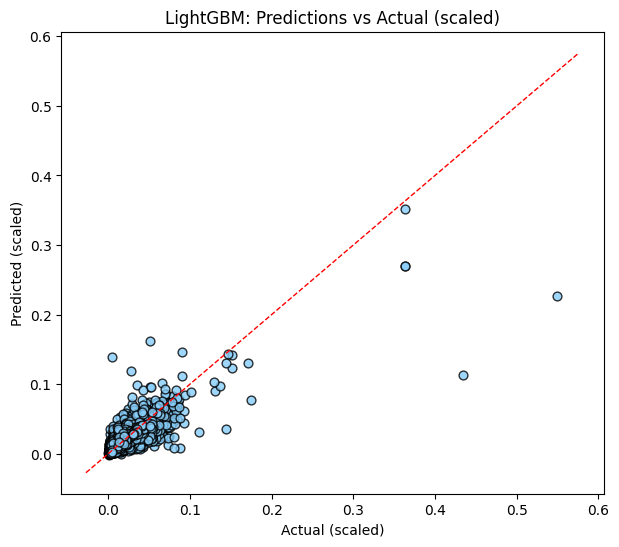

In [5]:
from lightgbm import LGBMRegressor
import numpy as np
import matplotlib.pyplot as plt

# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)
# ================== 4) TRAIN CATBOOST (SCALED) ==================
cb = LGBMRegressor(
   random_state=SEED, verbose=-1,n_estimators= 200, max_depth= 8, learning_rate= 0.2)
cb.fit(
    X_tr_s, y_tr_s
   
)

# ================== 5) PREDICT & SCATTER (SCALED) ==================
y_te_pred_s = cb.predict(X_te_s)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(y_te_s, y_te_pred_s, s=40, alpha=0.8,
           color="lightskyblue", edgecolors="k")

# Đường y = x theo giới hạn hiện tại của trục (không dùng 'lims')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.plot([min(x0, y0), max(x1, y1)], [min(x0, y0), max(x1, y1)],
        "--", lw=1, color="red")

ax.set_title("LightGBM: Predictions vs Actual (scaled)")
ax.set_xlabel("Actual (scaled)")
ax.set_ylabel("Predicted (scaled)")
plt.show()

In [6]:
# ================== SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d6/total 06.csv'
df = pd.read_csv(data_path)

features = [
  'Original_len',
'Txn Fee','logIndex','actualGasCost',
    'Blockno','DateTime_ts',  'nonce'
]
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# giữ test để dùng sau nếu cần; chỉ CV trên tập train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# ================== 20 EPOCHS × 10-FOLD ==================
EPOCHS, FOLDS = 20, 10
li = np.zeros((EPOCHS, 4), dtype=np.float64)   # [RMSE, MSE, MAE, R2]

for ep in range(EPOCHS):
    # shuffle dataset cho epoch này
    idx = np.random.permutation(len(X_train))
    X_ep = X_train.iloc[idx].reset_index(drop=True)
    y_ep = y_train.iloc[idx].reset_index(drop=True)

    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

    rmse_list, mse_list, mae_list, r2_list = [], [], [], []
    for tr, te in kf.split(X_ep):
        X_tr_raw, X_te_raw = X_ep.iloc[tr], X_ep.iloc[te]
        y_tr_raw, y_te_raw = y_ep.iloc[tr], y_ep.iloc[te]

        xs, ys = MinMaxScaler(), MinMaxScaler()
        X_tr = xs.fit_transform(X_tr_raw)
        X_te = xs.transform(X_te_raw)
        y_tr = ys.fit_transform(y_tr_raw.values.reshape(-1,1)).ravel()
        y_te = ys.transform(y_te_raw.values.reshape(-1,1)).ravel()

        model = LGBMRegressor(random_state=SEED, verbose=-1,n_estimators= 200, max_depth= 8, learning_rate= 0.2)
        model.fit(X_tr, y_tr)

        pred = model.predict(X_te)
        mse  = mean_squared_error(y_te, pred)
        rmse = float(np.sqrt(mse))
        mae  = mean_absolute_error(y_te, pred)
        r2   = r2_score(y_te, pred)

        rmse_list.append(rmse); mse_list.append(mse)
        mae_list.append(mae);   r2_list.append(r2)

    li[ep, :] = [np.mean(rmse_list), np.mean(mse_list), np.mean(mae_list), np.mean(r2_list)]

# ================== OUTPUT ==================
np.set_printoptions(precision=8, suppress=False)
print("array(" + np.array2string(li, separator=', ', prefix='array(') + ")")
print("\nMean over 20 runs (RMSE, MSE, MAE, R2):", li.mean(axis=0))
print("Std  over 20 runs (RMSE, MSE, MAE, R2):",  li.std(axis=0, ddof=1))

array([[6.73069920e-03, 4.83829182e-05, 3.43204023e-03, 7.42595008e-01],
       [6.71379672e-03, 4.79891370e-05, 3.43119784e-03, 7.42975253e-01],
       [6.75455706e-03, 4.83423374e-05, 3.43648130e-03, 7.39551722e-01],
       [6.70079156e-03, 4.71435424e-05, 3.43306879e-03, 7.42256227e-01],
       [6.77707722e-03, 4.89408245e-05, 3.43615393e-03, 7.38504410e-01],
       [6.70687759e-03, 4.77045410e-05, 3.43309909e-03, 7.42724766e-01],
       [6.70689779e-03, 4.76826690e-05, 3.43594064e-03, 7.42666412e-01],
       [6.71058970e-03, 4.81203336e-05, 3.43164689e-03, 7.43530903e-01],
       [6.69065124e-03, 4.70813731e-05, 3.43483334e-03, 7.43756397e-01],
       [6.74746772e-03, 4.88350055e-05, 3.44410884e-03, 7.41347662e-01],
       [6.69389419e-03, 4.76777109e-05, 3.42911037e-03, 7.44629245e-01],
       [6.74094949e-03, 4.93780290e-05, 3.42814233e-03, 7.43536517e-01],
       [6.70825141e-03, 4.73933908e-05, 3.43027615e-03, 7.42260342e-01],
       [6.74826474e-03, 4.79788481e-05, 3.43055359e

In [ ]:
#entrypoint address v07
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')
# ================== 0) SEED ==================
# ================== 0) SEED ==================
SEED = 42
np.random.seed(SEED)

# ================== 1) LOAD & PREP ==================
data_path = 'C:/Users/Multiplexon/Desktop/data/d7/total 7.csv'
df = pd.read_csv(data_path)

features = ['Original_len','Txn Fee','logIndex','actualGasCost',
            'Blockno','DateTime_ts','nonce']
target = 'Gas Used'

X = df[features].astype(float)
y = df[target].astype(float)

# ================== 2) HOLD-OUT ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# ================== 3) CROSS-VALIDATION (ALL METRICS ON SCALED) ==================
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

mse_scores, mae_scores, rmse_scores, r2_scores = [], [], [], []
all_true, all_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_train), start=1):
    # --- split fold ---
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # --- scale INSIDE fold (fit on train fold only) ---
    xs, ys = MinMaxScaler(), MinMaxScaler()
    X_tr_s = xs.fit_transform(X_tr)
    X_te_s = xs.transform(X_te)
    y_tr_s = ys.fit_transform(y_tr.values.reshape(-1, 1)).ravel()
    y_te_s = ys.transform(y_te.values.reshape(-1, 1)).ravel()

    # --- LightGBM ---
    model = LGBMRegressor(random_state=SEED, verbose=-1,n_estimators= 200, max_depth= 8, learning_rate= 0.2)
    model.fit(X_tr_s, y_tr_s)

    # --- predict & metrics on SCALED values ---
    y_pred_s = model.predict(X_te_s)



    mse  = mean_squared_error(y_te_s, y_pred_s)
    mae  = mean_absolute_error(y_te_s, y_pred_s)
    rmse = float(np.sqrt(mse))
    r2   = r2_score(y_te_s, y_pred_s)

    mse_scores.append(mse); mae_scores.append(mae)
    rmse_scores.append(rmse); r2_scores.append(r2)

    print(f"[Fold {fold}] (SCALED) MSE={mse:.6f} | RMSE={rmse:.6f} | MAE={mae:.6f} | R²={r2:.6f}")

# ================== 4) CV AVERAGE ==================
print("\n=== CV AVERAGE (SCALED) ===")
print(f"Avg MSE : {np.mean(mse_scores):.6f}")
print(f"Avg MAE : {np.mean(mae_scores):.6f}")
print(f"Avg RMSE: {np.mean(rmse_scores):.6f}")
print(f"Avg R²  : {np.mean(r2_scores):.6f}")

[Fold 1] (SCALED) MSE=0.000008 | RMSE=0.002906 | MAE=0.001437 | R²=0.881540
[Fold 2] (SCALED) MSE=0.000020 | RMSE=0.004473 | MAE=0.001463 | R²=0.733052
[Fold 3] (SCALED) MSE=0.000008 | RMSE=0.002884 | MAE=0.001433 | R²=0.886042
[Fold 4] (SCALED) MSE=0.000011 | RMSE=0.003279 | MAE=0.001504 | R²=0.849148
[Fold 5] (SCALED) MSE=0.000173 | RMSE=0.013136 | MAE=0.001598 | R²=0.347708
[Fold 6] (SCALED) MSE=0.000011 | RMSE=0.003341 | MAE=0.001378 | R²=0.844343
[Fold 7] (SCALED) MSE=0.000133 | RMSE=0.011530 | MAE=0.001604 | R²=-0.942206
[Fold 8] (SCALED) MSE=0.000020 | RMSE=0.004458 | MAE=0.001530 | R²=0.737829
[Fold 9] (SCALED) MSE=0.000127 | RMSE=0.011291 | MAE=0.001621 | R²=0.533367
[Fold 10] (SCALED) MSE=0.000015 | RMSE=0.003850 | MAE=0.001486 | R²=0.808678

=== CV AVERAGE (SCALED) ===
Avg MSE : 0.000053
Avg MAE : 0.001505
Avg RMSE: 0.006115
Avg R²  : 0.567950
